In [1]:
import numpy as np
import pandas as pd 
import stop_words
import json
from tqdm import trange
from tqdm import tqdm_notebook as tqdm

In [2]:
reviews = []
k = 4  # Dimensionality of the latent feature space
with open('/Users/karan/Downloads/yelp_data/yelp_academic_dataset_review.json') as fh:
    for r in fh:
        r1 = json.loads(r)
        
        r2 = { key: r1[key] for key in ['review_id','stars','user_id','business_id','text'] }
        reviews.append(r2)
df = pd.DataFrame.from_records(reviews)

In [ ]:
n_users = df.user_id.unique().shape[0]
n_business = df.business_id.unique().shape[0]

In [4]:
user = { key: index for index, key in enumerate(df.user_id.unique()) }
business = { key: index for index, key in enumerate(df.business_id.unique()) }

In [5]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from collections import Counter
import os
import random
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()

global all_words
all_words = set()
sw = set(stop_words.get_stop_words('en') +
     [chr(x) for x in range(ord('a'),ord('z')+1)] +
     [chr(x) for x in range(ord('A'),ord('Z')+1)])

def extract_tokens(blob):
    global all_words
    tokens = [stemmer.stem(i) for i in tokenizer.tokenize(blob.lower()) if not i in sw]
    all_words = all_words | set(tokens)
    return tokens
   
df['text'].apply(extract_tokens)
all_words = list(all_words)

In [6]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from collections import Counter
import os
import random
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()

global all_words
all_words = set()
sw = set(stop_words.get_stop_words('en') +
     [chr(x) for x in range(ord('a'),ord('z')+1)] +
     [chr(x) for x in range(ord('A'),ord('Z')+1)])

def extract_tokens(blob):
    global all_words
    tokens = [stemmer.stem(i) for i in tokenizer.tokenize(blob.lower()) if not i in sw]
    all_words = all_words | set(tokens)
    return tokens
   
df['text'].apply(extract_tokens)
df['stars'] /= 5
all_words = list(all_words)
word_topics = dict()

def extract_tokens(blob):
    return set([stemmer.stem(i) for i in tokenizer.tokenize(blob.lower()) if not i in sw])

df['tokens'] = df['text'].apply(extract_tokens)

In [7]:
import math

def updateTopic(epoch):
    for index, row in tqdm(df.iterrows(),desc="updateTopic: "+str(epoch),total=len(df)):
        bindex = business[row['business_id']]
        for word in row['tokens']:
            topic_scores = []
            word_id = all_words.index(word)
            for topic in range(k):
                topic_scores.append(math.exp(Q[topic,bindex] + weight_of_word_in_topic[word_id][topic]))
            topic_scores = np.array(topic_scores) / sum(topic_scores)
            new_topic = topic_scores.argmax()
            prev_topic = word_topics[all_words.index(word)]
            if new_topic != prev_topic:
                number_of_words_in_topic[word_id,prev_topic] -= 1
                number_of_words_in_topic[word_id,new_topic] += 1
                word_topics[all_words.index(word)] = new_topic

In [8]:
def update_word_weights():
    wZk = np.exp(number_of_words_in_topic).sum(axis=0)
    n_t = number_of_words_in_topic
    w = weight_of_word_in_topic
    Ew = np.exp(w)
    return w + -word_lambda*(n_t - np.divide(np.multiply(n_t.sum(axis=0),Ew),wZk))
#     for word_index in range(len(all_words)):
#         for topic in range(k):
#             twc = number_of_words_in_topic[word_index,topic]
#             e = math.exp(weight_of_word_in_topic[word_index,topic])
#             weight_of_word_in_topic[word_index,topic] += -word_lambda*(twc - sum(number_of_words_in_topic[:,topic])*e/wZk[topic])
#    return weight_of_word_in_topic / weight_of_word_in_topic.sum(axis=0)

In [9]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df, test_size=0.25)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [10]:
#Create two user-business matrices, one for training and another for testing
from scipy.sparse import csr_matrix, dok_matrix
import gc
gc.collect()
R = dok_matrix((n_business, n_users), dtype=np.float32)
I = dok_matrix((n_business, n_users), dtype=np.int8)
for line in train_data.itertuples():
    R[business[line[1]], user[line[5]]] = line[3]
    if line[3] > 0:
        I[business[line[1]], user[line[5]]] = 1

T = dok_matrix((n_business, n_users), dtype=np.float32)
I2 = dok_matrix((n_business, n_users), dtype=np.int8)
for line in test_data.itertuples():
    T[business[line[1]], user[line[5]]] = line[3]
    if line[3] > 0:
        I2[business[line[1]], user[line[5]]] = 1
R = R.asformat('csr')
I = I.asformat('csr')
T = T.asformat('csr')
I2 = I2.asformat('csr')

In [11]:
# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q,bp,bq,A):
    if len(Q.shape) > 1:
        bq = bq.reshape((1,Q.shape[1]))
    if len(P.shape) > 1:
        bp = bp.reshape((P.shape[1],1))      
    return np.dot(P.T,Q) + bp + bq + A

In [12]:
# Calculate the RMSE
def rmse(I,R,Q,P,BP,BQ,A):
    return np.sqrt(np.sum(I.multiply(np.square(R - prediction(P,Q,BP,BQ,A))))/I.getnnz())

In [13]:
import gc

lmbda = 0.75 # Regularisation weight
m, n = R.shape  # Number of users and business
n_epochs = 20  # Number of epochs
gamma=0.007  # Learning rate
word_lambda = 0.1

dA = 0
A = df['stars'].mean()

P = 5 * np.random.rand(k,m) # Latent user feature matrix
Q = 5 * np.random.rand(k,n) # Latent business feature matrix

number_of_words_in_topic = np.zeros((len(all_words),k),dtype=np.uint32)
weight_of_word_in_topic = np.zeros((len(all_words),k),dtype=np.float32)

for index, row in df.iterrows():
    wordTopicAssignment = {t: random.randint(0, k-1) for t in row['tokens']}
    for word, topic in wordTopicAssignment.items():
        word_topics[all_words.index(word)] = topic
        number_of_words_in_topic[all_words.index(word),topic] += 1

BP = np.zeros((m))
BQ = np.zeros((n))


dBP = np.zeros((m))
dBQ = np.zeros((n))

train_errors = []
test_errors = []
gc_counter = 0
#Only consider non-zero matrix 
users,items = R.nonzero()
for epoch in range(n_epochs):
    tusers = tqdm(
        users,
        desc="Epoch: "+str(epoch),
        leave=True,
        smoothing=None
    )
    dA = 0
    dBP = np.zeros((m))
    dBQ = np.zeros((n))
    for u, i in zip(tusers,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i],BP[u],BQ[i],A) # Calculate error for gradient
        P[:,u] += gamma * (  e * Q[:,i] ) - lmbda * P[:,u] # Update latent user feature matrix
        Q[:,i] += gamma * (  e * P[:,u] ) - lmbda * Q[:,i] # Update latent business feature matrix
        
        dA += gamma * ( e )
        
        dBP[u] += gamma * ( e ) # Update latent user bias vector
        dBQ[i] += gamma * ( e ) # Update latent business bias vector
                        
        if not gc_counter%1000:
            gc.collect()
            gc_counter = 1
        gc_counter += 1
    
    BP += dBP / len(R[u,:].nonzero())
    BQ += dBQ / len(R[:,i].nonzero())
    A += (dA) / len(users) - lmbda * A
    updateTopic(epoch)
    weight_of_word_in_topic = update_word_weights()
    gc.collect()
    train_rmse = rmse(I,R,Q,P,BP,BQ,A) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P,BP,BQ,A) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

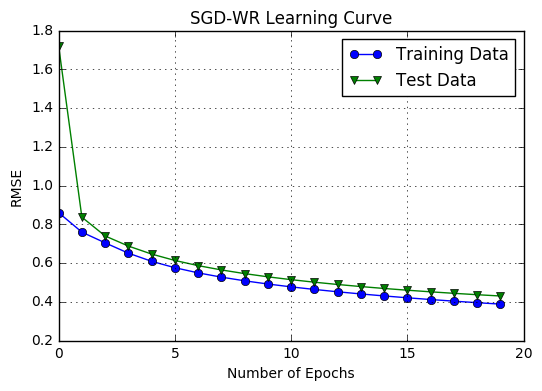

In [19]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [21]:
user_weights = (len(user) - np.argsort(Q, axis=1))/len(user)
business_weights = (len(business) - np.argsort(P, axis=1))/len(business)

In [22]:
for b in business:
    bdf = df[df['business_id'] == b]
    review_rating = 0
    for index,row in bdf.iterrows():
        total = 0
        for topic in range(k):
            total += user_weights[topic,user[row['user_id']]] + business_weights[topic,business[row['business_id']]]
        review_rating += row['stars'] * total / (k)
    review_rating /= len(bdf)
    print("Business: ",b,"Old Rating: ",bdf['stars'].mean()*5," New Rating: ",review_rating*5)

Business:  iQLLIdmJSt6LQHSjpZERLA Old Rating:  3.9999999999999996  New Rating:  3.83395925876
Business:  EoAY1JSVeJriBzId8lUQwQ Old Rating:  2.7078651685393265  New Rating:  2.81309575845
Business:  b9WZJp5L1RZr4F1nxclOoQ Old Rating:  4.25  New Rating:  4.47412788986
Business:  jLtS1O2tN7zNop8htTe9ZA Old Rating:  1.6666666666666665  New Rating:  1.61748104276
Business:  1_lU0-eSWJCRvNGk78Zh9Q Old Rating:  4.333333333333334  New Rating:  3.13546611627
Business:  e_U_FnpdKVgNb4mUN2cU_Q Old Rating:  2.8571428571428568  New Rating:  3.12688691037
Business:  xxWFOD46ubTSF3nPRM19BA Old Rating:  1.7142857142857146  New Rating:  1.97021998731
Business:  cE27W9VPgO88Qxe4ol6y_g Old Rating:  2.6  New Rating:  2.24822273074
Business:  Sktj1eHQFuVa-M4bgnEh8g Old Rating:  4.0  New Rating:  4.5594741329
Business:  6o3RK6rTcN3nw-j-r2nQmA Old Rating:  2.25  New Rating:  2.68897731862
Business:  yHTLTr-QN-loO_7XoxS8qg Old Rating:  2.9  New Rating:  3.21084062458
Business:  F04xyOUA2xnUoCiWpx9iJA Old Rat